# Apple Music Data Project

This project focuses on a dataset which was requested from apple data privacy and includes various information in relation to my music listening. The aim of the project is to find interesting insights into my music listening habits.

Readying the workspace with 'imports' and such

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
saved_style_state = matplotlib.rcParams.copy()

Importing primary dataset into workspace

In [3]:
csv_filepath = 'Apple Music Play Activity.csv'
listening_data = pd.read_csv(csv_filepath)
listening_data

json_filepath = 'Apple Music Library Tracks.json'
library_data = pd.read_json(json_filepath)
library_data

,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Is Part of Compilation,Album,Sort Album,Album Artist,...,Album Like Rating,Comments,Purchase Date,Rating,Album Rating,Remember Playback Position,Album Rating Method,Playlist Only Track,Display Work Name,Grouping
0,Song,182857262,The Library (Intro),Library (Intro),Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Song,182857266,I. Crawl,I. Crawl,Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Song,182857270,II. Worldstar,II. Worldstar,Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Song,182857474,Dial Up,Dial Up,Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Song,182857478,I. The Worst Guys (feat. Chance the Rapper),I. The Worst Guys (feat. Chance the Rapper),Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,Song,182895118,All Night,All Night,The Vamps & Matoma,Vamps & Matoma,False,Night & Day (Night Edition) [Deluxe Version],Night & Day (Night Edition) [Deluxe Version],The Vamps,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,Song,182895122,Rover (feat. DTG),Rover (feat. DTG),S1mba,S1mba,False,Rover (feat. DTG) - Single,Rover (feat. DTG) - Single,S1mba,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,Song,182895126,21,21,Polo G,Polo G,False,THE GOAT,GOAT,Polo G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2067,Song,182895130,Tommy Lee (feat. Post Malone),Tommy Lee (feat. Post Malone),Tyla Yaweh,Tyla Yaweh,False,Tommy Lee (feat. Post Malone) - Single,Tommy Lee (feat. Post Malone) - Single,Tyla Yaweh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
library_data.columns

Index(['Content Type', 'Track Identifier', 'Title', 'Sort Name', 'Artist',
       'Sort Artist', 'Is Part of Compilation', 'Album', 'Sort Album',
       'Album Artist', 'Genre', 'Track Year', 'Track Number On Album',
       'Track Count On Album', 'Disc Number Of Album', 'Disc Count Of Album',
       'Track Duration', 'Track Play Count', 'Date Added To Library',
       'Date Added To iCloud Music Library', 'Last Modified Date',
       'Last Played Date', 'Skip Count', 'Date of Last Skip', 'Is Purchased',
       'Audio File Extension', 'Is Checked', 'Copyright', 'Release Date',
       'Purchased Track Identifier', 'Apple Music Track Identifier',
       'Composer', 'Tag Matched Track Identifier', 'Track Like Rating',
       'Album Like Rating', 'Comments', 'Purchase Date', 'Rating',
       'Album Rating', 'Remember Playback Position', 'Album Rating Method',
       'Playlist Only Track', 'Display Work Name', 'Grouping'],
      dtype='object')

<function matplotlib.pyplot.show(*args, **kw)>

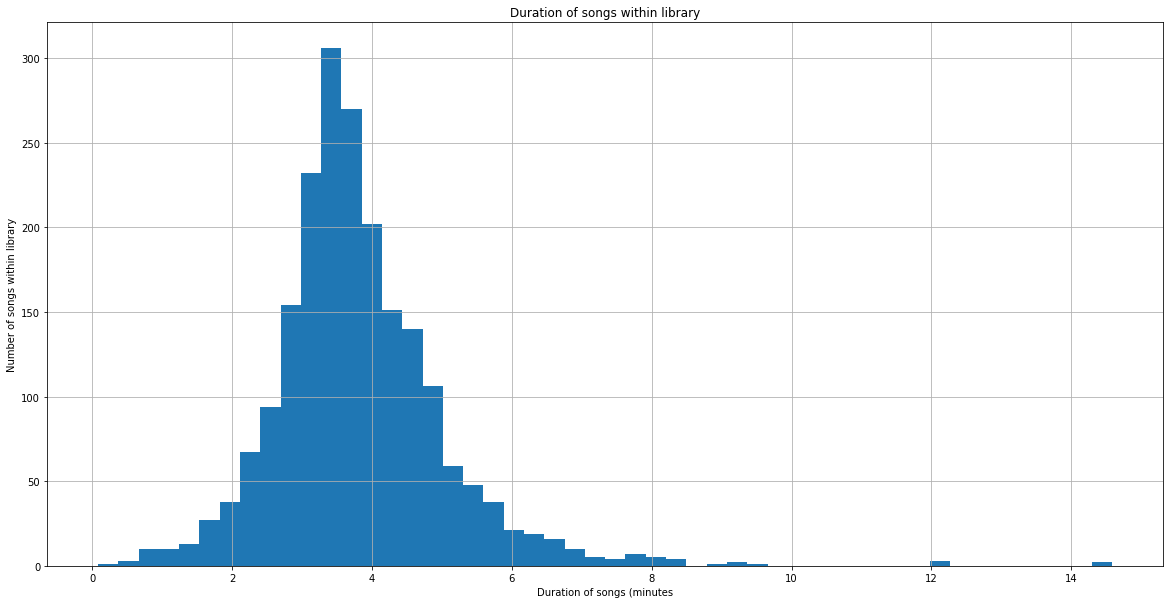

In [30]:
time_count = library_data["Track Duration"] / 60000
time_count
plt.hist(time_count, 50)
plt.xlabel('Duration of songs (minutes)')
plt.ylabel('Number of songs within library')
plt.title('Duration of songs within library')
plt.grid(True)
plt.show



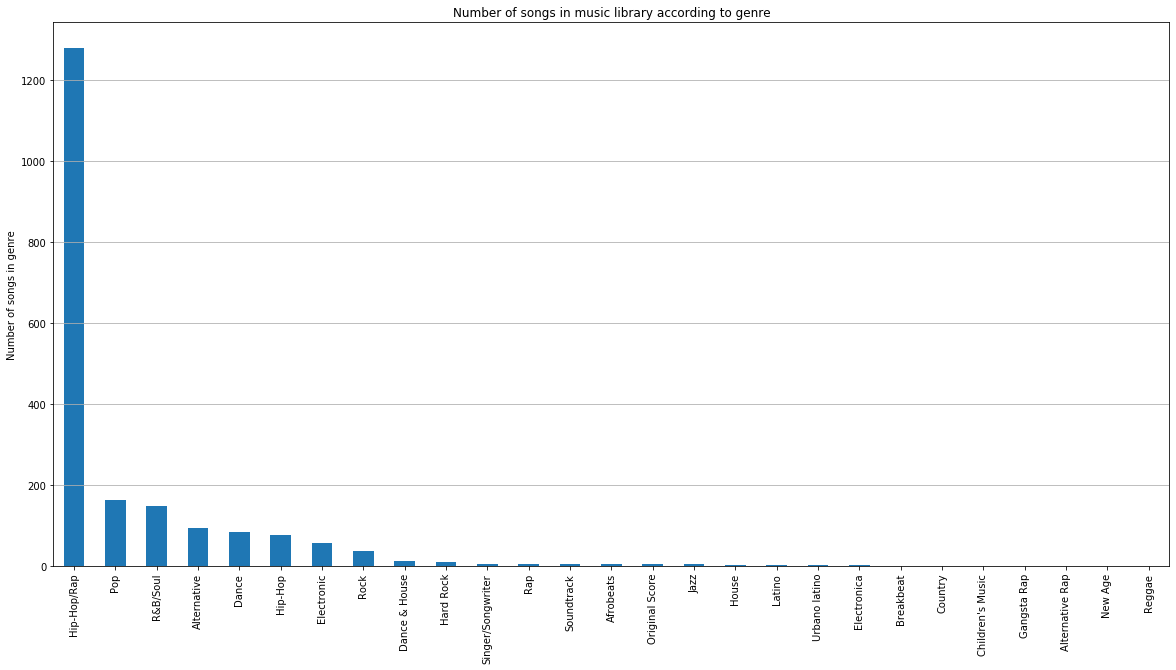

In [41]:
genre_count = library_data["Genre"].value_counts().plot(kind='bar')
plt.ylabel('Number of songs in genre')
plt.title('Number of songs in music library according to genre')
plt.axes().yaxis.grid()
plt.show()